In [3]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torchaudio #install pytorch in conda shell
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from torchsummary import summary # 
import src.preprocessor as preprocessor
#plt.style.use("ggplot")
torch.manual_seed(42)

# Speech Classification Pipeline
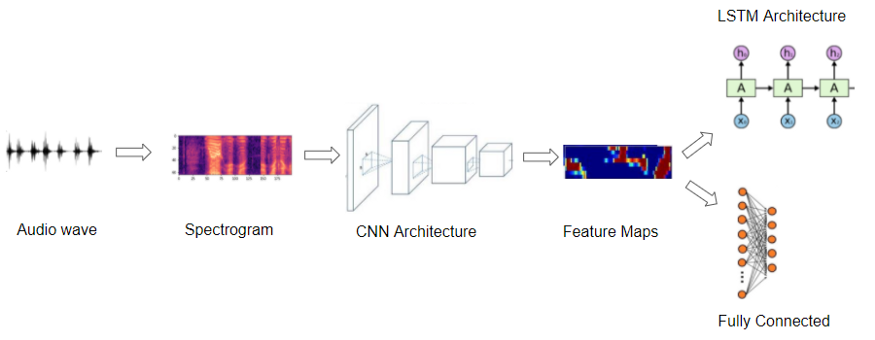

source: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

## Data exploration

Metadata from one recording per class

In [4]:
#accents_path = "./accentdb_extended/data" # The directory with the accent_db data
#accents_path = "C:\Users\peter\VoxPop\sample_output_directory"

accents_path="/Users/peter/VoxPop/sample_output_directory/"
os.listdir(accents_path)

['20240622_2146_ANT_features.csv',
 '20240622_2202_DUB_features.csv',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_10.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_11.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_12.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_13.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_14.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_15.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_16.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_17.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_18.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_19.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_20.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_21.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_22.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_23.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_24.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_25.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_26.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_27.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sam

In [5]:
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/" + accent_dir + "/"
    print(accent_dir)
    for file in os.listdir(dir_path):
        file_path = dir_path + file
        print(i)
        print(file_path)
        print(torchaudio.info(file_path))
        #x, sr = librosa.load("./accentdb_extended/data/bangla/bangla_s01_115.wav")
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y=x, sr=sr, color="b")
        plt.show()
        break

20240622_2146_ANT_features.csv


NotADirectoryError: [WinError 267] The directory name is invalid: '/Users/peter/VoxPop/sample_output_directory//20240622_2146_ANT_features.csv/'

## New DataFrame Handling


In [176]:
df1 = pd.read_csv(accents_path+'20240622_2202_DUB_features.csv', index_col=0)

In [177]:
df1[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...
3,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,3,DUB_Artane_M_20_Rec_0_Sample_3.wav,[0.01262519 0.01996171 0.02532474 ... 0.006640...,[[-24.227428 -26.599072 -47.74459 ... -36....,22050,[[-2.29787048e+02 -2.04622086e+02 -2.29607895e...,[[ 1.60471392e+00 1.60471392e+00 1.60471392e...,[[-4.01455164e+00 -4.01455164e+00 -4.01455164e...
4,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,4,DUB_Artane_M_20_Rec_0_Sample_4.wav,[ 0.00343075 -0.00091377 -0.00444303 ... -0.01...,[[-14.608098 -19.742035 -22.976656 ... -8.685...,22050,[[-3.32361755e+02 -2.94212708e+02 -2.60094482e...,[[ 2.11424866e+01 2.11424866e+01 2.11424866e...,[[-7.55291128e+00 -7.55291128e+00 -7.55291128e...


In [178]:
df2 = pd.read_csv(accents_path+'20240622_2146_ANT_features.csv', index_col=0)

In [179]:
df2[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,[-3.2596290e-09 -1.9790605e-09 -1.8626451e-09 ...,[[-35.601192 -23.076942 -25.175114 ... -27.925...,22050,[[-4.94363190e+02 -3.14765869e+02 -2.56520905e...,[[ 2.25450897e+01 2.25450897e+01 2.25450897e...,[[-1.33637514e+01 -1.33637514e+01 -1.33637514e...
1,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,[-0.06371997 0.01859411 0.04244079 ... 0.00...,[[-24.939114 -19.037073 -35.540073 ... -29....,22050,[[-2.00872665e+02 -1.89228134e+02 -2.05934250e...,[[ 1.72639978e+00 1.72639978e+00 1.72639978e...,[[ 8.44261360e+00 8.44261360e+00 8.44261360e...
2,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,[-0.0095884 -0.02918414 -0.02309626 ... -0.03...,[[-12.003866 -22.771717 -25.912066 ... -38....,22050,[[-2.69995789e+02 -2.09718552e+02 -1.99997101e...,[[ 7.18804741e+00 7.18804741e+00 7.18804741e...,[[-7.41261578e+00 -7.41261578e+00 -7.41261578e...
3,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,3,ANT_Antrim_R1_F_20_Rec_0_Sample_3.wav,[-0.02926175 -0.03246651 -0.03447114 ... 0.00...,[[-33.829704 -37.727036 -24.553106 ... -20....,22050,[[-3.19196564e+02 -3.07649445e+02 -3.14545471e...,[[ 9.71118259e+00 9.71118259e+00 9.71118259e...,[[-4.52929825e-01 -4.52929825e-01 -4.52929825e...
4,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,4,ANT_Antrim_R1_F_20_Rec_0_Sample_4.wav,[-0.02955866 -0.02219741 -0.02425817 ... 0.01...,[[ -8.041982 -9.362675 -27.606344 ... -42.156...,22050,[[-2.38382156e+02 -2.28491486e+02 -2.56093048e...,[[ 1.56459522e+01 1.56459522e+01 1.56459522e...,[[ 1.19706173e+01 1.19706173e+01 1.19706173e...


In [180]:
# Concatenate the DataFrames
input_df = pd.concat([df1, df2])

In [181]:
input_df.shape

(21594, 18)

In [182]:
input_df = input_df.reset_index(drop=True)

In [183]:
input_df[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...
3,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,3,DUB_Artane_M_20_Rec_0_Sample_3.wav,[0.01262519 0.01996171 0.02532474 ... 0.006640...,[[-24.227428 -26.599072 -47.74459 ... -36....,22050,[[-2.29787048e+02 -2.04622086e+02 -2.29607895e...,[[ 1.60471392e+00 1.60471392e+00 1.60471392e...,[[-4.01455164e+00 -4.01455164e+00 -4.01455164e...
4,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,4,DUB_Artane_M_20_Rec_0_Sample_4.wav,[ 0.00343075 -0.00091377 -0.00444303 ... -0.01...,[[-14.608098 -19.742035 -22.976656 ... -8.685...,22050,[[-3.32361755e+02 -2.94212708e+02 -2.60094482e...,[[ 2.11424866e+01 2.11424866e+01 2.11424866e...,[[-7.55291128e+00 -7.55291128e+00 -7.55291128e...


## Prepare the dataframe with dataset

In [184]:
input_df['counties'].value_counts()

counties
DUB    15100
ANT     3998
BEL     2496
Name: count, dtype: int64

In [185]:
input_df['counties'] = input_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [186]:
input_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [218]:
num_antbel=(input_df['counties']=='ANTBEL').sum()
num_antbel

6494

In [219]:
num_dub=(input_df['counties']=='DUB').sum()
num_dub

15100

In [222]:
weight_dub=num_dub/(num_dub+num_antbel)
weight_dub

0.6992683152727609

In [221]:
weight_antbel=num_antbel/(num_dub+num_antbel)
weight_antbel

0.30073168472723905

In [234]:
class_weights = torch.tensor([weight_dub, weight_antbel],dtype=torch.float)
class_weights

tensor([0.6993, 0.3007])

In [187]:
mapping = {'DUB': 0, 'ANTBEL': 1}
input_df['class_id'] = input_df['counties'].map(mapping)

In [194]:
input_df[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...,0
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...,0
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...,0
3,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,3,DUB_Artane_M_20_Rec_0_Sample_3.wav,[0.01262519 0.01996171 0.02532474 ... 0.006640...,[[-24.227428 -26.599072 -47.74459 ... -36....,22050,[[-2.29787048e+02 -2.04622086e+02 -2.29607895e...,[[ 1.60471392e+00 1.60471392e+00 1.60471392e...,[[-4.01455164e+00 -4.01455164e+00 -4.01455164e...,0
4,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,4,DUB_Artane_M_20_Rec_0_Sample_4.wav,[ 0.00343075 -0.00091377 -0.00444303 ... -0.01...,[[-14.608098 -19.742035 -22.976656 ... -8.685...,22050,[[-3.32361755e+02 -2.94212708e+02 -2.60094482e...,[[ 2.11424866e+01 2.11424866e+01 2.11424866e...,[[-7.55291128e+00 -7.55291128e+00 -7.55291128e...,0


In [199]:
input_df['genders'][input_df['genders']=='M'].count()

11948

In [200]:
input_df['genders'][input_df['genders']=='F'].count()

9646

In [201]:
9646+11948

21594

In [190]:
input_df[-5:-1]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
21589,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,65,95,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,[-0.0317689 -0.02877511 -0.01057131 ... 0.02...,[[-13.874187 -15.396595 -24.436401 ... -30....,22050,[[-2.73987335e+02 -2.49016769e+02 -2.36758804e...,[[ 1.19737828e+00 1.19737828e+00 1.19737828e...,[[-3.75298500e+00 -3.75298500e+00 -3.75298500e...,1
21590,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,65,96,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,[ 0.02460152 0.01588812 0.00461987 ... 0.00...,[[ -4.803353 -11.617571 -29.300434 ... -48....,22050,[[-3.01182892e+02 -2.77056152e+02 -2.26865936e...,[[ 1.06781569e+01 1.06781569e+01 1.06781569e...,[[-7.99286461e+00 -7.99286461e+00 -7.99286461e...,1
21591,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,65,97,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,[-0.00237683 -0.00117592 -0.00169209 ... 0.05...,[[-20.16156 -26.001833 -25.968048 ... -25.360...,22050,[[-3.59239716e+02 -3.24389343e+02 -3.12734009e...,[[ 3.50342774e+00 3.50342774e+00 3.50342774e...,[[-4.29514217e+00 -4.29514217e+00 -4.29514217e...,1
21592,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,65,98,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,[ 0.02828757 0.00067838 -0.03543036 ... 0.00...,[[-12.030594 -17.107288 -25.980743 ... -33.001...,22050,[[-2.15845810e+02 -2.13880249e+02 -2.44973221e...,[[-8.78343201e+00 -8.78343201e+00 -8.78343201e...,[[ 4.65423441e+00 4.65423441e+00 4.65423441e...,1


In [89]:
# create a dataframe from the input dataframes
df = pd.DataFrame(input_df[['sample file name','class_id','counties','recording num']])

In [90]:
df = df.rename(columns={'sample file name': 'file_path', 'class_id': 'class_id', 'counties': 'class_name'})

In [91]:
df

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,65
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,65
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,65
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,65


In [23]:
df.iloc[0]

file_path        DUB_Artane_M_20_Rec_0_Sample_0.wav
class_id                                          0
class_name                                      DUB
recording num                                     0
Name: 0, dtype: object

In [24]:
#df['file_path']=accents_path+df['file_path']

In [25]:
'''
# create a dataframe for further usage

rows = []
for i, file in enumerate(os.listdir(accents_path)):
    if file.endswith(".wav"):
        rows.append(["/" + accents_path + file, i, accent_dir])
    else:
        continue
    
    wav_files = [file for file in files_in_directory if file.endswith('.csv')]
    for file in os.listdir(dir_path):
        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])

df = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])
df.head(10)
'''

'\n# create a dataframe for further usage\n\nrows = []\nfor i, file in enumerate(os.listdir(accents_path)):\n    if file.endswith(".wav"):\n        rows.append(["/" + accents_path + file, i, accent_dir])\n    else:\n        continue\n    \n    wav_files = [file for file in files_in_directory if file.endswith(\'.csv\')]\n    for file in os.listdir(dir_path):\n        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])\n\ndf = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])\ndf.head(10)\n'

In [31]:
df.iloc[0]

file_path        DUB_Artane_M_20_Rec_0_Sample_0.wav
class_id                                          0
class_name                                      DUB
recording num                                     0
Name: 0, dtype: object

In [32]:
df.tail()

,file_path,class_id,class_name,recording num
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,65
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,65
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,65
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,65
21593,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_99.wav,1,ANTBEL,65


In [33]:
df.shape

(21594, 4)

## Data preprocessing

In [92]:
class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)
  
    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "file_path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = preprocessor.double_channel(aud)
        downsampl = preprocessor.downsample(rechannel)
        timed = preprocessor.append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [36]:
df_f = df[df['file_path'].str.contains('_F_')]
df_f

,file_path,class_id,class_name,recording num
266,DUB_Ballinteer_F_20_Rec_3_Sample_0.wav,0,DUB,3
267,DUB_Ballinteer_F_20_Rec_3_Sample_1.wav,0,DUB,3
268,DUB_Ballinteer_F_20_Rec_3_Sample_2.wav,0,DUB,3
269,DUB_Ballinteer_F_20_Rec_3_Sample_3.wav,0,DUB,3
270,DUB_Ballinteer_F_20_Rec_3_Sample_4.wav,0,DUB,3
...,...,...,...,...
20418,BEL_East_F_30_Rec_52_Sample_91.wav,1,ANTBEL,52
20419,BEL_East_F_30_Rec_52_Sample_92.wav,1,ANTBEL,52
20420,BEL_East_F_30_Rec_52_Sample_93.wav,1,ANTBEL,52
20421,BEL_East_F_30_Rec_52_Sample_94.wav,1,ANTBEL,52


In [37]:
df_f.shape

(9646, 4)

In [80]:
np.sort(df_f['recording num'].unique())

array([  0,   3,   4,   5,   8,   9,  10,  11,  12,  13,  14,  15,  17,
        18,  19,  20,  25,  26,  27,  29,  30,  31,  32,  33,  35,  36,
        37,  39,  40,  41,  42,  44,  45,  46,  50,  51,  52,  53,  55,
        56,  57,  58,  61,  62,  63,  64,  69,  73,  76,  77,  82,  83,
        84,  86,  87,  91,  92,  93,  95,  96,  98, 100, 102, 103, 107,
       108, 109, 112, 113, 114, 115, 116, 122, 123, 124, 125, 129, 130,
       131, 134, 136, 137, 138, 141, 142, 151, 152, 153, 154, 157, 158,
       159, 160, 164, 166], dtype=int64)

In [81]:
df_f['recording num'].unique().shape

(95,)

In [38]:
df_m = df[df['file_path'].str.contains('_M_')]
df_m

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,65
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,65
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,65
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,65


In [82]:
np.sort(df_m['recording num'].unique())

array([  0,   1,   2,   4,   5,   6,   7,   8,  11,  12,  13,  14,  15,
        16,  17,  18,  21,  22,  23,  24,  25,  28,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  43,  44,  45,  46,  47,  48,  49,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  70,  71,  72,  74,  75,  78,  79,  80,  81,  85,
        88,  89,  90,  94,  97,  99, 101, 104, 105, 106, 110, 111, 117,
       118, 119, 120, 121, 126, 127, 128, 132, 133, 135, 139, 140, 143,
       144, 145, 146, 147, 148, 149, 150, 155, 156, 161, 162, 163, 165],
      dtype=int64)

In [68]:
df_m['recording num'].unique().shape

(104,)

In [39]:
df_m.shape

(11948, 4)

In [40]:
df_m[df_m['file_path'].str.contains(('ANT'))].count()

file_path        2581
class_id         2581
class_name       2581
recording num    2581
dtype: int64

In [41]:
df_m[df_m['file_path'].str.contains(('DUB'))].count()

file_path        7517
class_id         7517
class_name       7517
recording num    7517
dtype: int64

In [42]:
#Select either the male or the female subset of samples only
#df=df_m
df=df_f

In [43]:
df=df.reset_index(drop=True)

In [93]:
df

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,65
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,65
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,65
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,65


In [45]:
df.iloc[0]

file_path        DUB_Ballinteer_F_20_Rec_3_Sample_0.wav
class_id                                              0
class_name                                          DUB
recording num                                         3
Name: 0, dtype: object

## Split into train and validate datasets

In [137]:
# Select samples for training and validation by SPEAKER i.e. by recording number
# Random split of 80:20 between training and validation
num_items = df.shape[0]
num_train = round(num_items * 0.7)
num_val = num_items - num_train


In [138]:
print(num_items)
print(num_train)
print(num_val)

21594
15116
6478


In [101]:
unique_recordings = df['recording num'].unique()
np.random.shuffle(unique_recordings)  # Shuffle the unique values

# Determine the split index
split_index = int(len(unique_recordings) * 0.7)


In [102]:
df['recording num'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166], dtype=int64)

In [105]:
unique_recordings

array([ 40, 156,  19,  39,  93, 151,  88, 105, 122, 141,  75,  78, 130,
        70, 162,  22, 145,  90, 166, 107,   7, 103,  38,  55,  20, 144,
        81,  17, 108, 161, 115,  28,  35,  65, 109, 117, 163,  71, 114,
        18, 153,  79,  33, 123,  98,  99, 101, 113,   9, 140,  68,  45,
       104,  86,  49,   6, 121, 149,  72, 110,  76, 137,   1,  43,   5,
       148,  29, 146, 128, 158, 155,   3,  82,  13,  41,  58,  87, 139,
        92,  11, 143, 131, 120, 129,  37,  25,  62,  64,  42,  48,   4,
       152,  94,  77,  69,  34, 147,  14,  26,  54, 100,  83, 135,  16,
        95, 116,  36, 157, 111, 134,  73,  74,  66,  12, 159,   2, 160,
       102,  63,  97,  96,  91,  53, 106, 118, 119,  59,  52,  24,  31,
       142,  60,  23, 127, 126, 124,  57, 138,  85, 112,  61, 165,  67,
       136,  84,   0,  89, 164, 132, 133,  21,  27,  51,  56,  15,  50,
        46, 125,   8, 154,  30,  32,  80,  47, 150,  10,  44], dtype=int64)

In [106]:
unique_recordings.shape

(167,)

In [107]:
unique_recordings.max()

166

In [109]:
unique_recordings[:split_index]

array([ 40, 156,  19,  39,  93, 151,  88, 105, 122, 141,  75,  78, 130,
        70, 162,  22, 145,  90, 166, 107,   7, 103,  38,  55,  20, 144,
        81,  17, 108, 161, 115,  28,  35,  65, 109, 117, 163,  71, 114,
        18, 153,  79,  33, 123,  98,  99, 101, 113,   9, 140,  68,  45,
       104,  86,  49,   6, 121, 149,  72, 110,  76, 137,   1,  43,   5,
       148,  29, 146, 128, 158, 155,   3,  82,  13,  41,  58,  87, 139,
        92,  11, 143, 131, 120, 129,  37,  25,  62,  64,  42,  48,   4,
       152,  94,  77,  69,  34, 147,  14,  26,  54, 100,  83, 135,  16,
        95, 116,  36, 157, 111, 134,  73,  74,  66,  12, 159,   2],
      dtype=int64)

In [110]:
unique_recordings[split_index:]

array([160, 102,  63,  97,  96,  91,  53, 106, 118, 119,  59,  52,  24,
        31, 142,  60,  23, 127, 126, 124,  57, 138,  85, 112,  61, 165,
        67, 136,  84,   0,  89, 164, 132, 133,  21,  27,  51,  56,  15,
        50,  46, 125,   8, 154,  30,  32,  80,  47, 150,  10,  44],
      dtype=int64)

In [120]:
# Split the unique values into two sets (70% and 30%)
recording_train = unique_recordings[:split_index]
recording_val = unique_recordings[split_index:]

# Create two new DataFrames based on the split unique values
df_train = df[df['recording num'].isin(recording_train)].reset_index(drop=True)
df_val = df[df['recording num'].isin(recording_val)].reset_index(drop=True)

In [112]:
df_train.shape

(14780, 4)

In [121]:
df_train['recording num'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  22,  25,  26,  28,  29,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  45,  48,  49,  54,  55,  58,
        62,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  81,  82,  83,  86,  87,  88,  90,  92,  93,  94,
        95,  98,  99, 100, 101, 103, 104, 105, 107, 108, 109, 110, 111,
       113, 114, 115, 116, 117, 120, 121, 122, 123, 128, 129, 130, 131,
       134, 135, 137, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149,
       151, 152, 153, 155, 156, 157, 158, 159, 161, 162, 163, 166],
      dtype=int64)

In [116]:
df_train['recording num'].unique().shape

(116,)

In [119]:
df_val.shape

(6814, 4)

In [117]:
df_val['recording num'].unique()

array([  0,   8,  10,  15,  21,  23,  24,  27,  30,  31,  32,  44,  46,
        47,  50,  51,  52,  53,  56,  57,  59,  60,  61,  63,  67,  80,
        84,  85,  89,  91,  96,  97, 102, 106, 112, 118, 119, 124, 125,
       126, 127, 132, 133, 136, 138, 142, 150, 154, 160, 164, 165],
      dtype=int64)

In [118]:
df_val['recording num'].unique().shape

(51,)

In [146]:
train_ds = SpeechDataset(df_train, accents_path)
train_dl=DataLoader(train_ds, batch_size=15, shuffle=True)

In [147]:
val_ds = SpeechDataset(df_val, accents_path)
val_dl=DataLoader(val_ds, batch_size=15, shuffle=False)

In [ ]:
'''
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)
'''

In [ ]:
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)

In [148]:
print("dataset")
print(num_items)
print("training")
print(num_train)
print("validation")
print(num_val)

dataset
21594
training
15116
validation
6478


In [149]:
train_ds

In [150]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

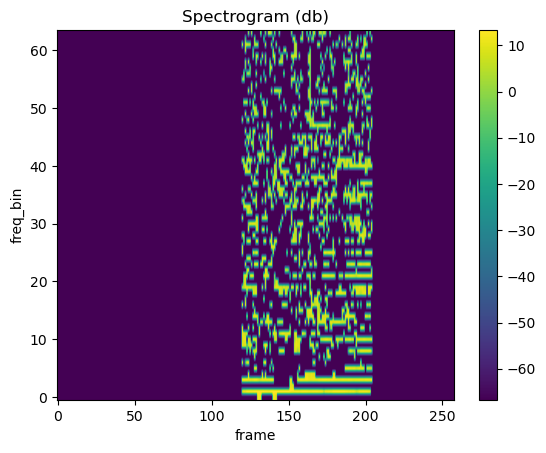

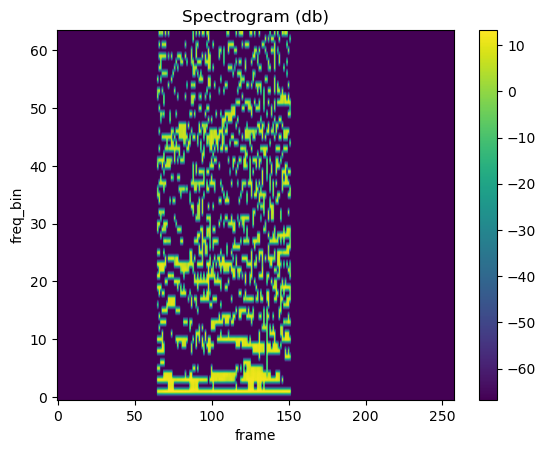

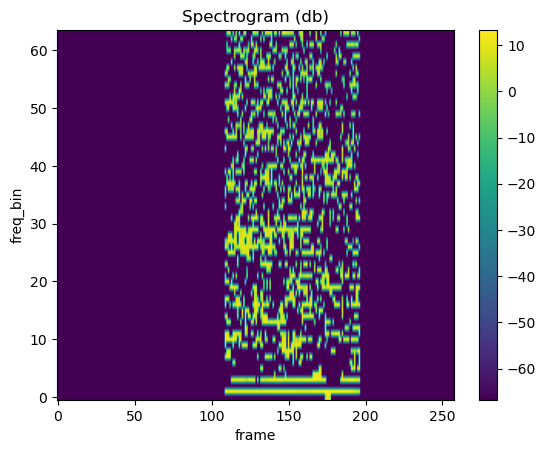

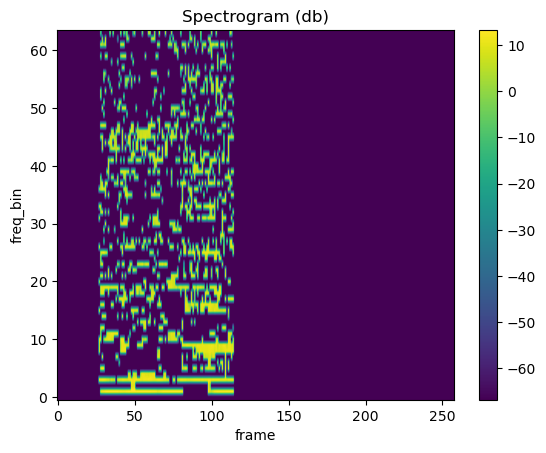

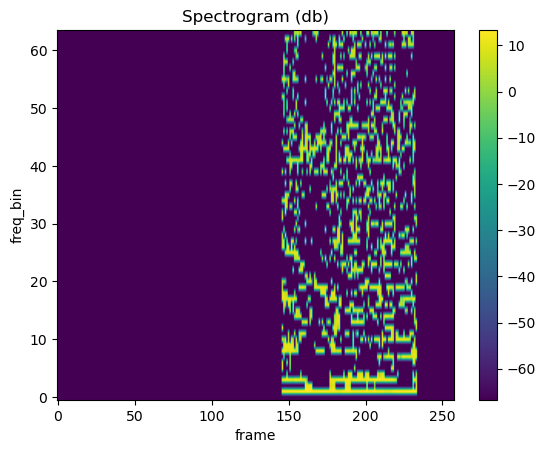

In [151]:
for i in range(5):
    plot_spectrogram(train_ds[i][0][0])

## Classifier model

In [152]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # Wrap the Convolutional Bl~ocks
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(0.5)
        #self.lin = nn.Linear(in_features=32, out_features=9) #used with the 9 class classfication problem of the original accent_db paper
        self.lin = nn.Linear(in_features=32, out_features=2) #used with CrossEntropyLoss with the two classes onlyh
        #self.lin = nn.Linear(in_features=32, out_features=1)

    def forward(self, inp_x):
        inp_x = self.conv(inp_x)
        inp_x = self.ap(inp_x)
        inp_x = inp_x.view(inp_x.shape[0], -1)
        inp_x = self.dropout(inp_x)
        inp_x = self.lin(inp_x)
        return inp_x

In [153]:
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        #self.correct += torch.sum(y_pred == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

## Training and Inference

In [154]:
# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device
summary(model, (2, 64, 258), 11)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [11, 8, 32, 129]             152
              ReLU-2           [11, 8, 32, 129]               0
       BatchNorm2d-3           [11, 8, 32, 129]              16
            Conv2d-4           [11, 16, 16, 65]           1,168
              ReLU-5           [11, 16, 16, 65]               0
       BatchNorm2d-6           [11, 16, 16, 65]              32
            Conv2d-7            [11, 32, 8, 33]           4,640
              ReLU-8            [11, 32, 8, 33]               0
       BatchNorm2d-9            [11, 32, 8, 33]              64
AdaptiveAvgPool2d-10             [11, 32, 1, 1]               0
          Dropout-11                   [11, 32]               0
           Linear-12                    [11, 2]              66
Total params: 6,138
Trainable params: 6,138
Non-trainable params: 0
-----------------------------------

In [236]:
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss() #original
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#epochs = 5
epochs = 10

# training loop
train_loss_history = []
train_accuracy_history = []

valid_loss_history = []
valid_accuracy_history = []

accuracy = AccuracyMetric()

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        #print(loss)
        loss.backward()
        optimizer.step()
        accuracy.update(y_predicted, y_batch)
        batch_train_loss.append(loss.item())

    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()

    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            batch_valid_loss.append(loss_val.item())

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()

    valid_loss_history.append(mean_epoch_loss_valid)
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()

    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f}"
    )

[INFO] Epoch: 1


100%|██████████| 455/455 [00:20<00:00, 22.31it/s]


Train loss: 0.2077, Train accuracy:  0.8709
Validation loss: 0.4516, Validation accuracy:  0.8154
[INFO] Epoch: 2


100%|██████████| 455/455 [00:19<00:00, 22.91it/s]


Train loss: 0.2088, Train accuracy:  0.8735
Validation loss: 0.4099, Validation accuracy:  0.8281
[INFO] Epoch: 3


100%|██████████| 455/455 [00:19<00:00, 23.31it/s]


Train loss: 0.2082, Train accuracy:  0.8711
Validation loss: 0.4348, Validation accuracy:  0.8124
[INFO] Epoch: 4


100%|██████████| 455/455 [00:19<00:00, 23.11it/s]


Train loss: 0.2041, Train accuracy:  0.8714
Validation loss: 0.4443, Validation accuracy:  0.7948
[INFO] Epoch: 5


100%|██████████| 455/455 [00:19<00:00, 22.90it/s]


Train loss: 0.2026, Train accuracy:  0.8725
Validation loss: 0.4933, Validation accuracy:  0.8201
[INFO] Epoch: 6


100%|██████████| 455/455 [00:22<00:00, 20.35it/s]


Train loss: 0.1992, Train accuracy:  0.8806
Validation loss: 0.4112, Validation accuracy:  0.8274
[INFO] Epoch: 7


100%|██████████| 455/455 [00:21<00:00, 21.55it/s]


Train loss: 0.1980, Train accuracy:  0.8796
Validation loss: 0.5061, Validation accuracy:  0.7793
[INFO] Epoch: 8


100%|██████████| 455/455 [00:19<00:00, 22.90it/s]


Train loss: 0.1962, Train accuracy:  0.8802
Validation loss: 0.4307, Validation accuracy:  0.8167
[INFO] Epoch: 9


100%|██████████| 455/455 [00:20<00:00, 22.58it/s]


Train loss: 0.1945, Train accuracy:  0.8829
Validation loss: 0.5786, Validation accuracy:  0.8009
[INFO] Epoch: 10


100%|██████████| 455/455 [00:19<00:00, 22.97it/s]


Train loss: 0.1930, Train accuracy:  0.8811
Validation loss: 0.4841, Validation accuracy:  0.7841


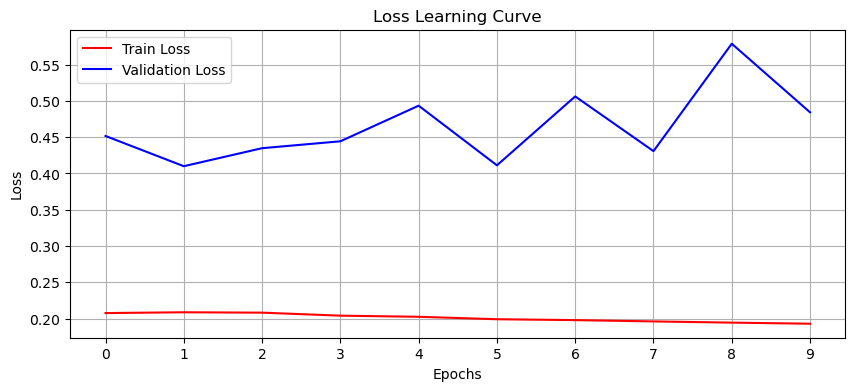

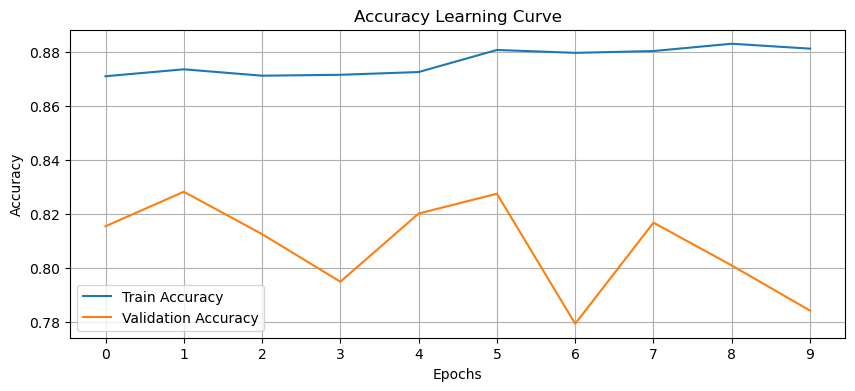

In [238]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_loss_history, color="r")
plt.xticks(range(epochs))
plt.plot(valid_loss_history, color="b")
plt.xticks(range(epochs))
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
ax.grid(True)

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_accuracy_history)
plt.xticks(range(epochs))
plt.plot(valid_accuracy_history)
plt.xticks(range(epochs))

plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
ax.grid(True)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
confmat = confusion_matrix(y_true=y_batch, y_pred=y_predicted)
print(confmat)

In [ ]:
X_batch.shape

In [ ]:
y_batch

In [ ]:
(y_predicted)

In [ ]:
y_predicted.argmax(-1)

In [ ]:
y_batch

In [ ]:
# Compare the tensors element-wise
matches = torch.eq(y_predicted.argmax(-1), y_batch)

# Count the number of matches
num_matches = matches.sum().item()

# Display the number of matching values
print(f'Number of matching values: {num_matches}')

In [ ]:
12/14

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch)

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()